# Capstone Project
## The Battle of Neighborhoods: Where to Open an Italian Restaurant in NYC?
**Written'n'coded by Vadim Kropanev**
***
### Introduction
New York City is commonly known as one of the most popular multicultural centers of the Earth. Moreover, its economic growth and perspectives attract businesses, families and individuals from all over the world, therefore, the city’s diversity is not only being supported but also achieving new heights. With almost 700,000 Manhattan inhabitants reporting Italian ancestry, the need to find and enjoy Italian cuisine is on the rise. This report explores which neighborhoods and boroughs of New York City have the most as well as the best Italian restaurants to answer the main question: **Where should I open an Italian restaurant in New York City?**

### Data Section
In order to determine the possible options for opening a new restaurant, the data on New York City neighborhoods and boroughs **to include boundaries, latitudes, longitudes, restaurants, restaurant ratings and tips** are required:
* New York City data containing the neighborhoods and boroughs, latitudes, and longitudes will be obtained from the data source: https://cocl.us/new_york_dataset;
* All data related to locations and quality of Italian restaurants will be obtained via the FourSquare API utilized via the Request library in Python.

### Methodology Section
* Data will be collected from https://cocl.us/new_york_dataset, cleaned and processed into a dataframe;
* FourSquare API will be used to locate all venues;
* Italian restaurants will be extracted from these venues;
* Ratings, tips, and likes by users will be counted and added to the dataframe;
* Data will be sorted based on rankings;
* Finally, the data will be visually assessed using graphing tools from various Python libraries.

### Problem Statement
* What are the best locations for Italian cuisine in New York City?
* In which neighborhood and/or borough should I open an Italian restaurant to have the best chance of being successful?

### Analysis Section
#### Loading all important libraries

In [1]:
import pandas as pd    # data analysis library
import numpy as np     # fundamental package for scientific computing 
import requests        # HTTP library
import os              # operating system interfaces

!pip install folium
import folium          # package to visualize data on a leaflet map 

!pip install geopy
from geopy.geocoders import Nominatim   # geocoding software

import matplotlib.pyplot as plt         # plotting library
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import seaborn as sns  # statistical data visualization library

print('Done!')

Done!


#### Defining key variables

In [2]:
# @hidden_cell
CLIENT_ID = 'YPEL2IDPBQGUR2334CEOVZI44KCKSGKUY1QX3ZBEOYHWZYBF' # your FourSquare ID
CLIENT_SECRET = 'OBLBWPBL03TV51EMQWSDH5ZH1ZD0FZIJ2PGSZKY0FIEHEPV5' # your FourSquare Secret
VERSION = '20200525' # FourSquare API version

#### Defining functions to be used later

In [3]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent = "foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude


def get_venues(lat, lng):
    # set variables
    radius = 400
    LIMIT = 100
    # URL to fetch data from FourSquare API
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data = results["response"]["groups"][0]['items']
    venue_details = []
    for row in venue_data:
        try:
            venue_id = row['venue']['id']
            venue_name = row['venue']['name']
            venue_category = row['venue']['categories'][0]['name']
            venue_details.append([venue_id, venue_name, venue_category])
        except KeyError:
            pass
    column_names = ['ID','Name','Category']
    df = pd.DataFrame(venue_details, columns = column_names)
    return df


def get_venue_details(venue_id):
    # URL to fetch data from FourSquare API
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    venue_data = results['response']['venue']
    venue_details = []
    try:
        venue_id = venue_data['id']
        venue_name = venue_data['name']
        venue_likes = venue_data['likes']['count']
        venue_rating = venue_data['rating']
        venue_tips = venue_data['tips']['count']
        venue_details.append([venue_id, venue_name, venue_likes, venue_rating, venue_tips])
    except KeyError:
        pass
    column_names = ['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details, columns = column_names)
    return df


def get_new_york_data():
    url = 'https://cocl.us/new_york_dataset'
    response = requests.get(url).json()
    # all data is present in features label
    features = response['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns = column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index = True)
    return new_york_data

#### Getting data of New York City

In [4]:
nyc_data = get_new_york_data()
print('There are', nyc_data.shape[0], 'rows and', nyc_data.shape[1], 'columns')
nyc_data.head()

There are 306 rows and 4 columns


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### Visualizing bar chart «Neighborhoods per Borough: NYC»

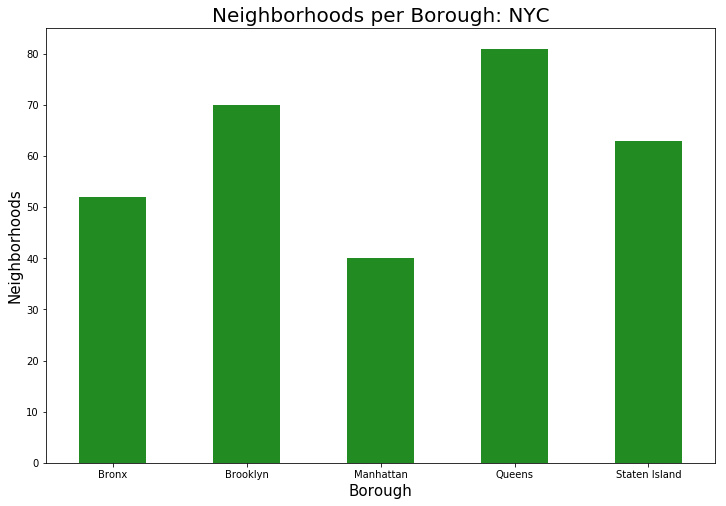

In [5]:
color = "forestgreen"
nyc_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize = (12,8), color = color)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

* We can see that **the highest** number of neigborhoods is in **Queens** and **the lowest** is in **Manhattan**.

#### Preparing neighborhood list that contains Italian resturants

In [6]:
column_names = ['Borough', 'Neighborhood', 'ID', 'Name']
it_rest = pd.DataFrame(columns = column_names)
count = 1
for row in nyc_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude = row
    venues = get_venues(Latitude, Longitude)
    italian_resturants = venues[venues['Category'] == 'Italian Restaurant']
    for resturant_detail in italian_resturants.values.tolist():
        id, name, category = resturant_detail
        it_rest = it_rest.append({'Borough': Borough,
                               'Neighborhood': Neighborhood, 
                               'ID': id,
                               'Name' : name}, ignore_index = True)
    count += 1


it_rest.to_csv('it_rest.csv') # save the information so far to a .csv file due to limited calls on FourSquare
it_rest = pd.read_csv('it_rest.csv', index_col = 0)
print('There are', it_rest.shape[0], 'rows and', it_rest.shape[1], 'columns')
it_rest.head()

There are 205 rows and 4 columns


,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn
1,Bronx,Pelham Parkway,4bf96ae65317a593d837017f,Enzo's
2,Bronx,Pelham Parkway,4b47f069f964a5208c4426e3,Pasta Pasta
3,Bronx,City Island,4514ed4df964a520e5391fe3,Artie's Steak and Seafood
4,Bronx,Parkchester,5197f6507dd2310725c35f1e,Lorraine's Bar and Grill


#### Visualizing bar chart «Italian Resturants per Borough: NYC»

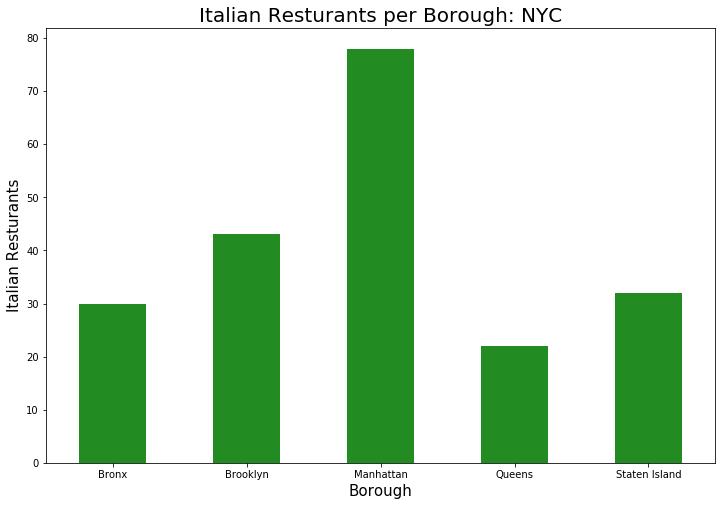

In [7]:
it_rest.groupby('Borough')['ID'].count().plot.bar(figsize = (12,8), color = color)
plt.title('Italian Resturants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

* We can see that **the highest** number of Italian restaurants is in **Manhattan** and **the lowest** is in **Queens**;
* Recall that **the highest** number of neighborhoods is in **Queens** and **the lowest** is in **Manhattan**.

#### Visualizing bar chart «Italian Resturants per Neighborhood: NYC»

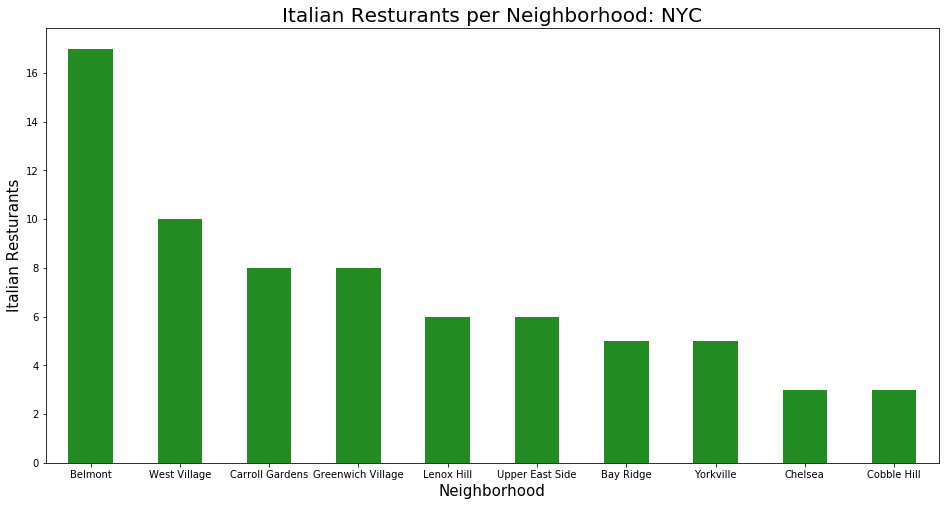

In [8]:
top_10 = 10 # top number for graphing
it_rest.groupby('Neighborhood')['ID'].count().nlargest(top_10).plot.bar(figsize=(16,8), color=color)
plt.title('Italian Resturants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('Italian Resturants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.show()

* We can see that **the highest** number of Italian restaurants is in **Belmont** which is a neigborhood of **Bronx**.

#### Getting data of Italian restaurants in Belmont, Bronx

In [9]:
belmont_it_rest = it_rest[it_rest['Neighborhood'] == 'Belmont']
print('There are', belmont_it_rest.shape[0], 'rows and', belmont_it_rest.shape[1], 'columns')
belmont_it_rest

There are 17 rows and 4 columns


,Borough,Neighborhood,ID,Name
6,Bronx,Belmont,4acf80aef964a52025d420e3,Tino's Delicatessen
7,Bronx,Belmont,4af71916f964a520cf0522e3,Michaelangelo's Coal Fired Brick Oven Pizza Re...
8,Bronx,Belmont,59050f51b23dfa5f6649e678,Arthur Avenue Fiasco
9,Bronx,Belmont,4c9b9e7b9c663704b90463fd,Gerbasi Ristorante
10,Bronx,Belmont,4bb6470cef159c7465b275f7,Calabria Pork Store
11,Bronx,Belmont,4b5514c4f964a5207cda27e3,Enzo's
12,Bronx,Belmont,4af0fa29f964a52060e021e3,Antonio's Trattoria
13,Bronx,Belmont,4aa425bef964a5208e4520e3,Dominick's Restaurant
14,Bronx,Belmont,4c79d294278eb713f6a05580,Cafe al Mercato
15,Bronx,Belmont,4b5a4c8ff964a52049bb28e3,Emilia's Restaurant


* We can see that there are **17 Italian restaurants** in **Belmont, Bronx**.

#### Getting data of Italian restaurants' reviews

In [10]:
column_names = ['Borough', 'Neighborhood', 'ID', 'Name', 'Likes', 'Rating', 'Tips']
it_rest_st = pd.DataFrame(columns = column_names)
count = 1
for row in it_rest.values.tolist():
    Borough, Neighborhood, ID, Name = row
    try:
        venue_details = get_venue_details(ID)
        id, name, likes, rating, tips = venue_details.values.tolist()[0]
    except IndexError:
        # We will assign 0 value for these resturants as they may have been 
        # recently opened or their details do not exist in FourSquare Database
        id, name, likes, rating, tips = [0]*5
    it_rest_st = it_rest_st.append({'Borough': Borough,
                                'Neighborhood': Neighborhood, 
                                'ID': id,
                                'Name': name,
                                'Likes': likes,
                                'Rating': rating,
                                'Tips': tips}, ignore_index = True)
    count += 1


it_rest_st.to_csv('it_rest_st.csv') # save the information so far to a .csv file due to limited calls on FourSquare
it_rest_st = pd.read_csv('it_rest_st.csv', index_col = 0)
print('There are', it_rest_st.shape[0], 'rows and', it_rest_st.shape[1], 'columns')
it_rest_st.head()

There are 205 rows and 7 columns


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,511edb6de4b0d58346fd272d,Patrizia's Of Woodlawn,18,8.3,14
1,Bronx,Pelham Parkway,4bf96ae65317a593d837017f,Enzo's,26,8.7,11
2,Bronx,Pelham Parkway,4b47f069f964a5208c4426e3,Pasta Pasta,9,6.4,8
3,Bronx,City Island,4514ed4df964a520e5391fe3,Artie's Steak and Seafood,44,8.3,27
4,Bronx,Parkchester,0,0,0,0.0,0


#### Wrangling data of Italian restaurants' reviews

In [11]:
it_rest_st.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 0 to 204
Data columns (total 7 columns):
Borough         205 non-null object
Neighborhood    205 non-null object
ID              205 non-null object
Name            205 non-null object
Likes           205 non-null int64
Rating          205 non-null float64
Tips            205 non-null int64
dtypes: float64(1), int64(2), object(4)
memory usage: 12.8+ KB


In [12]:
it_rest_st['Likes'] = it_rest_st['Likes'].astype('float64')
it_rest_st['Tips'] = it_rest_st['Tips'].astype('float64')

In [13]:
it_rest_st.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205 entries, 0 to 204
Data columns (total 7 columns):
Borough         205 non-null object
Neighborhood    205 non-null object
ID              205 non-null object
Name            205 non-null object
Likes           205 non-null float64
Rating          205 non-null float64
Tips            205 non-null float64
dtypes: float64(3), object(4)
memory usage: 12.8+ KB


In [14]:
it_rest_st.describe()

,Likes,Rating,Tips
count,205.000000,205.000000,205.000000
mean,141.165854,7.391707,55.351220
std,299.493464,2.137086,123.483958
min,0.000000,0.000000,0.000000
25%,14.000000,7.300000,6.000000
50%,35.000000,8.000000,16.000000
75%,104.000000,8.500000,40.000000
max,2491.000000,9.500000,1136.000000


* We can see that **the mean rating** of all Italian restaurants in NYC is about **7.4 out of 10**;
* **The mean number of likes** is about **141**;
* **The mean number of tips** is about **55**.

#### Finding restaurant with maximum Likes

In [15]:
it_rest_st.iloc[it_rest_st['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                Little Italy
ID              4cc6222106c25481d7a4a047
Name                 Rubirosa Ristorante
Likes                               2491
Rating                               9.3
Tips                                 824
Name: 113, dtype: object

#### Finding restaurant with maximum Ratings

In [16]:
it_rest_st.iloc[it_rest_st['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood                    Bushwick
ID              5a98aed16a59506d7a60d67c
Name                          Carmenta’s
Likes                                 57
Rating                               9.5
Tips                                  21
Name: 39, dtype: object

#### Finding restaurant with maximum Tips

In [17]:
it_rest_st.iloc[it_rest_st['Tips'].idxmax()]

Borough                    Staten Island
Neighborhood               West Brighton
ID              4b5b58dbf964a52088f628e3
Name                        Panini Grill
Likes                                 21
Rating                               8.6
Tips                                1136
Name: 156, dtype: object

#### Finding average rating of Italian resturants for each borough

In [18]:
borough_st = it_rest_st.groupby('Borough', as_index = False).mean()[['Borough', 'Rating']]
borough_st.columns = ['Borough', 'Average Rating']
borough_st.sort_values(['Average Rating'], ascending=False)

,Borough,Average Rating
2,Manhattan,8.260256
0,Bronx,7.610000
1,Brooklyn,7.572093
3,Queens,7.127273
4,Staten Island,5.009375


#### Visualizing bar chart «Average Rating of Italian Resturants for Each Borough»

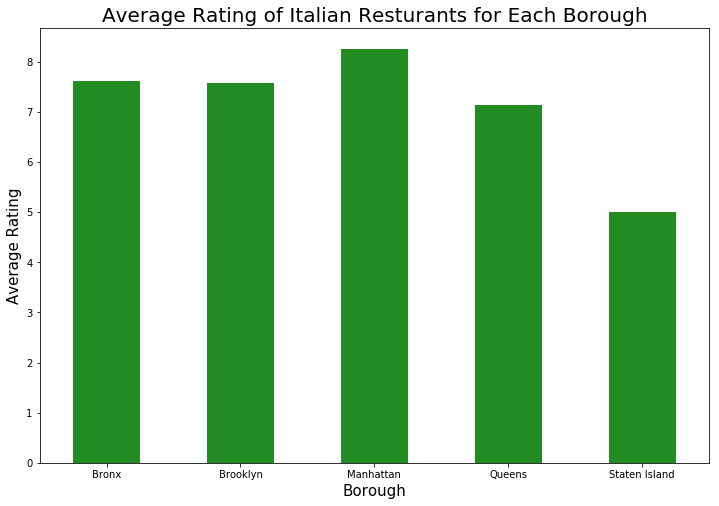

In [19]:
it_rest_st.groupby('Borough').mean()['Rating'].plot.bar(figsize = (12,8), color = color)
plt.title('Average Rating of Italian Resturants for Each Borough', fontsize=20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.show()

* We can see that **Manhattan** has **the highest** average rating and **Staten Island** has **the lowest**;
* **Overall average rating**, excluding Staten Island, is fluctuating **from 7 to 8**.

#### Finding top 10 of neighborhoods with the highest mean rating

In [20]:
neighborhood_st = it_rest_st.groupby('Neighborhood', as_index = False).mean()[['Neighborhood', 'Rating']]
neighborhood_st.columns = ['Neighborhood', 'Average Rating']
neighborhood_st.sort_values(['Average Rating'], ascending=False).head(10)

,Neighborhood,Average Rating
12,Bushwick,9.500000
11,Boerum Hill,9.100000
45,Hamilton Heights,9.000000
53,Little Italy,9.000000
86,Tribeca,8.900000
67,North Side,8.800000
44,Greenwich Village,8.800000
65,Noho,8.800000
25,Corona,8.700000
81,Soho,8.666667


* We can see that **the highest** average rating of Italian restaurants is in **Bushwick, Brooklyn** which is **9.5**.

#### Creating map of the neighborhoods with an average rating greater than or equal to 8

In [21]:
neighborhood_st = neighborhood_st[neighborhood_st['Average Rating'] >= 8.0]
neighborhood_st = pd.merge(neighborhood_st, nyc_data, on = 'Neighborhood')
neighborhood_st = neighborhood_st[['Borough', 'Neighborhood', 'Latitude', 'Longitude', 'Average Rating']]
neighborhood_st['Average Rating'] = np.around(neighborhood_st['Average Rating'], 2)
neighborhood_st.head()

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Auburndale,40.761730,-73.791762,8.2
1,Brooklyn,Boerum Hill,40.685683,-73.983748,9.1
2,Brooklyn,Bushwick,40.698116,-73.925258,9.5
3,Manhattan,Carnegie Hill,40.782683,-73.953256,8.5
4,Bronx,City Island,40.847247,-73.786488,8.3


In [22]:
# create map of NYC
nyc_map = folium.Map(location = geo_location('New York'), zoom_start = 12)
# instantiate a feature group for the restaurant ratings in the dataframe
ratings = folium.map.FeatureGroup()
# loop through the restaurant ratings and add each one to the ratings feature group
for lat, lng, in neighborhood_st[['Latitude', 'Longitude']].values:
    ratings.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius = 10, # define how big you want the circle markers to be
            color = 'yellow',
            fill = True,
            fill_color = 'blue',
            fill_opacity = 0.7
        )
    )


neighborhood_st['Label'] = neighborhood_st['Neighborhood'] + ', ' + neighborhood_st['Borough'] + ' (' + neighborhood_st['Average Rating'].map(str) + ')'
# add pop-up text to each marker on the map
for lat, lng, label in neighborhood_st[['Latitude', 'Longitude', 'Label']].values:
    folium.Marker([lat, lng], popup = label).add_to(nyc_map)        
# add restaurant ratings to map
nyc_map.add_child(ratings)

### Results and Conclusion Section
Let us sum up all ideas from this research:
* **The highest** number of **neighborhoods** is in **Queens** and **the lowest** is in **Manhattan**;
***
* **The highest** number of **Italian restaurants** is in **Manhattan** and **the lowest** is in **Queens**;
***
* **The highest** number of **Italian restaurants** is in **Belmont** which is a neighborhood of **Bronx**;
***
* The number of **Italian restaurants** in **Belmont** is **17**;
***
* **The mean rating** of all **Italian restaurants in NYC** is about **7.4 out of 10**;
***
* **The mean number of likes** is about **141**;
***
* **The mean number of tips** is about **55**;
***
* The restaurant with **maximum Likes** is **Rubirosa Ristorante in Little Italy, Manhattan (2491 likes)**;
***
* The restaurant with **maximum Rating** is **Carmenta’s in Bushwick, Brooklyn (9.5)**;
***
* The restaurant with **maximum Tips** is **Panini Grill in West Brighton, Staten Island (1136 tips)**;
***
* **Manhattan** has **the highest average rating** and **Staten Island** has **the lowest**;
***
* **Overall average rating**, excluding Staten Island, is fluctuating **from 7 to 8**;
***
* **The highest average rating** of Italian restaurants is in **Bushwick, Brooklyn** which is **9.5**.

Personally, I would state that **Manhattan** is **the best locations for Italian cuisine** in NYC. To have the best shot of success, I would **open an Italian restaurant** in **Queens**. Queens has multiple neighborhoods with average ratings exceeding 8.0 of a scale of 1.0 to 10.0 and has the least number of Italian restaurants making competition easier than in other boroughs. Finally, I can consider **Rubirosa Ristorante, Carmenta’s and Panini Grill** as **the most suitable places to try Italian cuisine**. All the above research is highly depended on the adequacy and accuracy of FourSquare Database, therefore, a more comprehensive analysis and future work would need to incorporate data from other external databases.